<a href="https://colab.research.google.com/github/Rahulx911/DELHIVERY-TASK/blob/main/advanced_picking_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install ultralytics opencv-python matplotlib
!pip install ensemble-boxes
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
!pip install --upgrade torchvision
!pip install --upgrade torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ensemble-boxes  # Install the 'ensemble-boxes' library
!pip install ultralytics
!pip install torchvision opencv-python
!pip install paddleocr paddlepaddle torchvision opencv-python
!pip install paddleocr
!pip install paddlepaddle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 384.3 kB/s eta 0:00:00
Cloning into 'yolov5'...
remote: Enumerating objects: 17582, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 17582 (delta 0), reused 0 (delta 0), pack-reused 17579 (from 2)
Receiving objects: 100% (17582/17582), 16.81 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (11970/11970), done.
/content/yolov5
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

Loading models (this may take a while)...


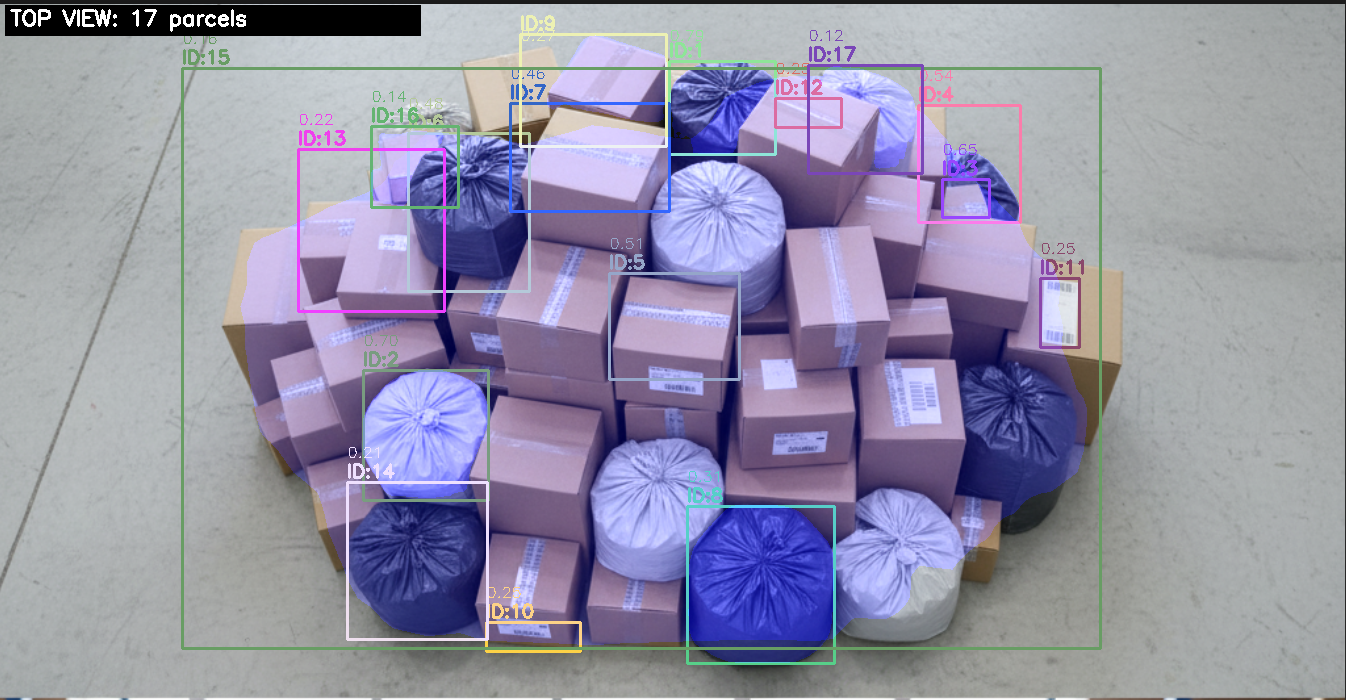

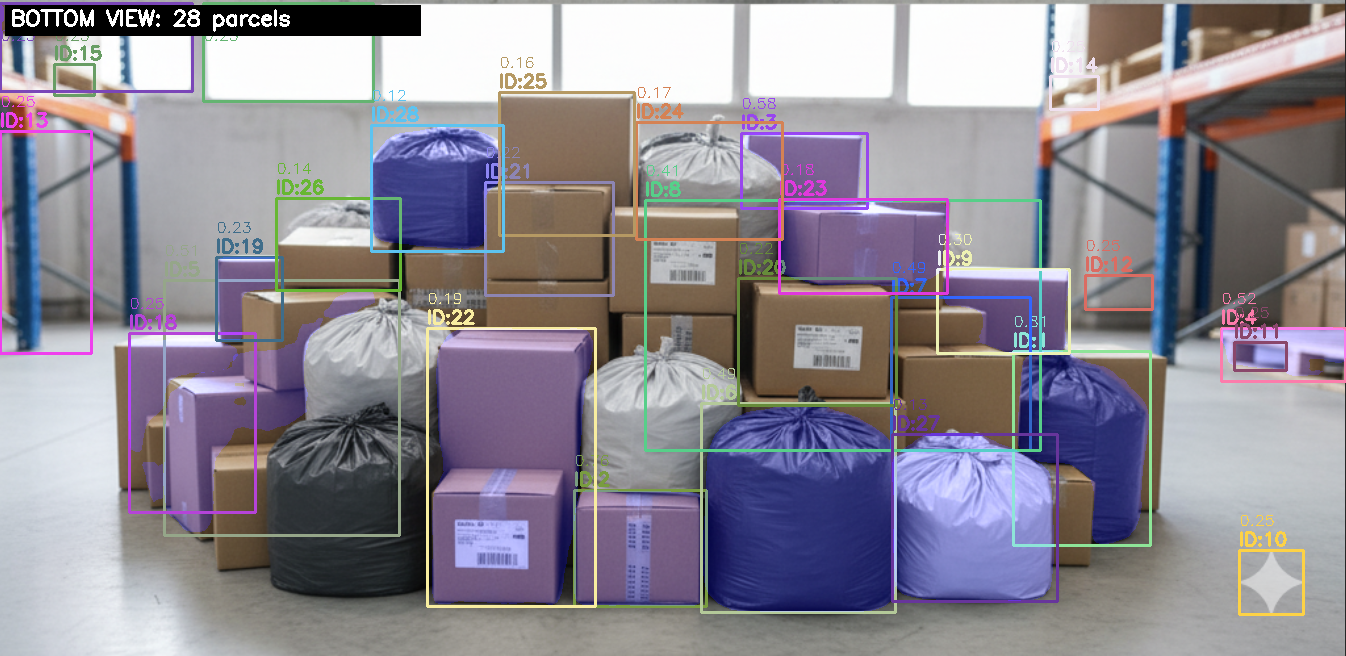

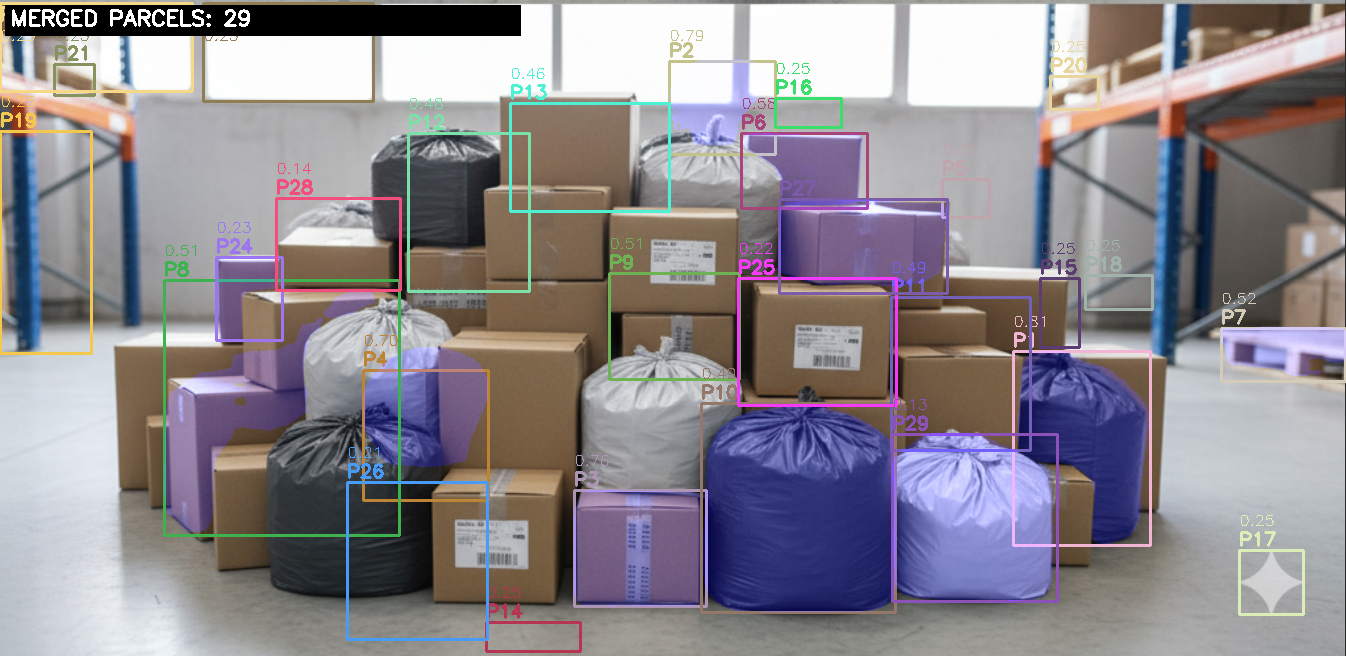

In [3]:
import os
import gc
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.ops import nms
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd


TOP_IMG_PATH = "/content/Screenshot 2025-10-06 at 11.55.52 PM.png"
BOTTOM_IMG_PATH = "/content/Screenshot 2025-10-06 at 11.56.03 PM.png"
OUTPUT_PATH = "/content/parcel_output_optimized_merged.png"
CONF_THRESH = 0.12
MIN_AREA_PX = 350
MAX_AREA_RATIO = 0.65
NMS_IOU = 0.25
MASK_BIN_THRESH = 0.45
MERGE_IOU_THRESH = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache(); gc.collect()

#  Utility functions
def safe_nms(boxes_np, scores_np, iou_thresh=NMS_IOU):
    if boxes_np is None or len(boxes_np) == 0:
        return np.array([], dtype=int)
    boxes_t = torch.tensor(boxes_np, dtype=torch.float32, device=device)
    scores_t = torch.tensor(scores_np, dtype=torch.float32, device=device)
    with torch.no_grad():
        keep = nms(boxes_t, scores_t, iou_thresh).cpu().numpy()
    return keep

def clip_boxes(boxes, h, w):
    boxes[:, 0] = np.clip(boxes[:, 0], 0, w-1)
    boxes[:, 2] = np.clip(boxes[:, 2], 0, w-1)
    boxes[:, 1] = np.clip(boxes[:, 1], 0, h-1)
    boxes[:, 3] = np.clip(boxes[:, 3], 0, h-1)
    return boxes

def process_model_outputs(boxes, scores, masks, img_h, img_w, source_tag="model"):
    dets = []
    if boxes is None or len(boxes) == 0:
        return dets
    boxes = boxes.astype(float)
    clip_boxes(boxes, img_h, img_w)
    for i, (b, s) in enumerate(zip(boxes, scores)):
        x1,y1,x2,y2 = map(float, b)
        w = max(1.0, x2 - x1)
        h = max(1.0, y2 - y1)
        area = w * h
        cx = x1 + w/2.0
        cy = y1 + h/2.0
        mask_bin = None
        if masks is not None and len(masks) > i:
            m = masks[i]
            if m.ndim == 3 and m.shape[0] == 1:
                m = m[0]
            if m.shape != (img_h, img_w):
                m = cv2.resize(m.astype(np.float32), (img_w, img_h), interpolation=cv2.INTER_NEAREST)
            mask_bin = (m >= MASK_BIN_THRESH).astype(np.uint8)
        dets.append({
            "bbox": np.array([x1,y1,x2,y2], dtype=float),
            "score": float(s),
            "area": float(area),
            "centroid": (float(cx), float(cy)),
            "mask": mask_bin,
            "source": source_tag
        })
    return dets

def simple_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    edge_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = float(w) * float(h)
        if 800 < area < 50000:
            aspect_ratio = max(w/h, h/w) if h>0 else 999
            if aspect_ratio < 4:
                edge_boxes.append([float(x), float(y), float(x+w), float(y+h)])
    return np.array(edge_boxes, dtype=float) if edge_boxes else np.array([], dtype=float)

def iou_box(a, b):
    ax1,ay1,ax2,ay2 = a
    bx1,by1,bx2,by2 = b
    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)
    if inter_x2 <= inter_x1 or inter_y2 <= inter_y1:
        return 0.0
    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    area_a = max(0.0, (ax2-ax1)) * max(0.0, (ay2-ay1))
    area_b = max(0.0, (bx2-bx1)) * max(0.0, (by2-by1))
    union = area_a + area_b - inter_area
    return inter_area / union if union > 0 else 0.0

#  Inference function for a single image
def run_inference_single(img_path, mask_model, fast_model, conf_thresh=CONF_THRESH):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    img_h, img_w = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    tensor = F.to_tensor(img_rgb).to(device)

    detections = []
    # Mask R-CNN
    with torch.no_grad():
        out = mask_model([tensor])[0]
    boxes1 = out.get('boxes', torch.empty((0,4))).cpu().numpy()
    scores1 = out.get('scores', torch.empty((0,))).cpu().numpy()
    masks1 = out.get('masks', None)
    if masks1 is not None:
        masks1 = masks1.detach().cpu().numpy()
    dets1 = process_model_outputs(boxes1, scores1, masks1, img_h, img_w, "maskrcnn")
    detections.extend(dets1)
    del out
    torch.cuda.empty_cache(); gc.collect()

    # Faster R-CNN
    with torch.no_grad():
        out2 = fast_model([tensor])[0]
    boxes2 = out2.get('boxes', torch.empty((0,4))).cpu().numpy()
    scores2 = out2.get('scores', torch.empty((0,))).cpu().numpy()
    dets2 = process_model_outputs(boxes2, scores2, None, img_h, img_w, "fasterrcnn")
    detections.extend(dets2)
    del out2
    torch.cuda.empty_cache(); gc.collect()

    # Edge-based proposals
    edge_boxes = simple_edge_detection(img_bgr)
    if edge_boxes.size:
        edge_scores = np.ones(len(edge_boxes)) * 0.25
        dets_edge = process_model_outputs(edge_boxes, edge_scores, None, img_h, img_w, "edge")
        detections.extend(dets_edge)

    # initial filtering by area & score
    if len(detections) == 0:
        return img_bgr, []

    boxes_arr = np.array([d['bbox'] for d in detections], dtype=float)
    scores_arr = np.array([d['score'] for d in detections], dtype=float)
    areas = (boxes_arr[:,2]-boxes_arr[:,0]) * (boxes_arr[:,3]-boxes_arr[:,1])
    img_area = img_h * img_w
    keep = (areas >= MIN_AREA_PX) & (areas <= img_area * MAX_AREA_RATIO) & (scores_arr >= conf_thresh)
    boxes_arr, scores_arr = boxes_arr[keep], scores_arr[keep]
    dets_filtered = [d for k,d in zip(keep, detections) if k]

    if len(boxes_arr) > 0:
        keep_idx = safe_nms(boxes_arr, scores_arr, iou_thresh=NMS_IOU)
        final_dets = [dets_filtered[i] for i in keep_idx]
    else:
        final_dets = []

    del tensor; torch.cuda.empty_cache(); gc.collect()
    return img_bgr, final_dets

#  Load models once
print("Loading models (this may take a while)...")
mask_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device).eval()
fast_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device).eval()

#  Run on both images
top_bgr, top_dets = run_inference_single(TOP_IMG_PATH, mask_model, fast_model, conf_thresh=CONF_THRESH)
bottom_bgr, bottom_dets = run_inference_single(BOTTOM_IMG_PATH, mask_model, fast_model, conf_thresh=CONF_THRESH)

# Free models (optional) - keep if memory needed
del mask_model, fast_model
torch.cuda.empty_cache(); gc.collect()

# Prepare detections with view tag
for d in top_dets:
    d['view'] = 'top'
for d in bottom_dets:
    d['view'] = 'bottom'

all_dets = top_dets + bottom_dets

#  Merge across views using IoU (2D merge)
if len(all_dets) == 0:
    merged_groups = []
else:
    indices = list(range(len(all_dets)))
    indices.sort(key=lambda i: all_dets[i]['score'], reverse=True)
    assigned = set()
    merged_groups = []
    for i in indices:
        if i in assigned:
            continue
        group = [i]
        assigned.add(i)
        bi = all_dets[i]['bbox']
        for j in indices:
            if j in assigned:
                continue
            bj = all_dets[j]['bbox']
            if iou_box(bi, bj) >= MERGE_IOU_THRESH:
                group.append(j)
                assigned.add(j)
        merged_groups.append(group)

merged_parcels = []
for gid, group in enumerate(merged_groups, start=1):
    members = [all_dets[idx] for idx in group]
    members.sort(key=lambda x: x['score'], reverse=True)
    best = members[0]
    views = sorted(list(set([m['view'] for m in members])))
    sources = sorted(list(set([m['source'] for m in members])))
    merged_parcels.append({
        "ID": gid,
        "bbox": best['bbox'],
        "score": best['score'],
        "centroid": best['centroid'],
        "mask": best['mask'],
        "best_view": best['view'],
        "members": members,
        "views": views,
        "sources": sources
    })

# Visualization (top, bottom, merged on bottom)
def safe_resize_mask_to(mask, target_shape):
    """
    Resize mask (H_mask,W_mask) or None to target_shape (H_target, W_target).
    Returns uint8 mask in {0,1} with shape target_shape.
    """
    if mask is None:
        return None
    try:
        h_t, w_t = target_shape
        if mask.shape == (h_t, w_t):
            return (mask > 0).astype(np.uint8)
        resized = cv2.resize(mask.astype(np.uint8), (w_t, h_t), interpolation=cv2.INTER_NEAREST)
        return (resized > 0).astype(np.uint8)
    except Exception:
        return np.zeros(target_shape, dtype=np.uint8)

def draw_detections(img_bgr, dets, title="VIEW"):
    out = img_bgr.copy()
    H_t, W_t = out.shape[:2]
    if len(dets) == 0:
        cv2.rectangle(out, (5, 5), (300, 40), (0, 0, 0), -1)
        cv2.putText(out, f"{title}: 0 parcels", (12, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        return out
    np.random.seed(42)
    colors = [tuple(int(x) for x in np.random.randint(50,255,3)) for _ in range(len(dets))]
    for i, d in enumerate(dets):
        x1,y1,x2,y2 = map(int, map(round, d['bbox']))
        color = colors[i]
        cv2.rectangle(out, (x1,y1), (x2,y2), color, 2)
        cv2.putText(out, f"ID:{i+1}", (x1, max(20, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        cv2.putText(out, f"{d['score']:.2f}", (x1, max(40, y1-25)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        if d['mask'] is not None:
            mask_resized = safe_resize_mask_to(d['mask'], (H_t, W_t))
            mask_vis = (mask_resized * 255).astype(np.uint8)
            colored_mask = np.zeros_like(out)
            colored_mask[:,:,0] = mask_vis
            out = cv2.addWeighted(out, 1.0, colored_mask, 0.25, 0)
    cv2.rectangle(out, (5,5), (420,35), (0,0,0), -1)
    cv2.putText(out, f"{title}: {len(dets)} parcels", (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    return out

top_vis = draw_detections(top_bgr, top_dets, "TOP VIEW")
bottom_vis = draw_detections(bottom_bgr, bottom_dets, "BOTTOM VIEW")

# For merged visualization show canonical IDs on bottom image.
merged_vis = bottom_bgr.copy()
H_m, W_m = merged_vis.shape[:2]
np.random.seed(24)
colors = [tuple(int(x) for x in np.random.randint(50,255,3)) for _ in range(len(merged_parcels))]
for i, p in enumerate(merged_parcels):
    x1,y1,x2,y2 = map(int, map(round, p['bbox']))
    color = colors[i]
    cv2.rectangle(merged_vis, (x1,y1), (x2,y2), color, 2)
    cv2.putText(merged_vis, f"P{p['ID']}", (x1, max(20, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    cv2.putText(merged_vis, f"{p['score']:.2f}", (x1, max(40, y1-25)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    if p['mask'] is not None:
        mask_resized = safe_resize_mask_to(p['mask'], (H_m, W_m))
        mask_vis = (mask_resized * 255).astype(np.uint8)
        colored_mask = np.zeros_like(merged_vis)
        colored_mask[:,:,0] = mask_vis
        merged_vis = cv2.addWeighted(merged_vis, 1.0, colored_mask, 0.25, 0)

cv2.rectangle(merged_vis, (5,5), (520,35), (0,0,0), -1)
cv2.putText(merged_vis, f"MERGED PARCELS: {len(merged_parcels)}", (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

# Save and display as before
cv2.imwrite(OUTPUT_PATH, merged_vis)
cv2_imshow(top_vis)
cv2_imshow(bottom_vis)
cv2_imshow(merged_vis)




In [40]:
#Task 2 - Dimensional and Volumetric Analysis

import math
import numpy as np
import cv2

print("TASK 2: DIMENSIONAL AND VOLUMETRIC ANALYSIS")


# Check connectivity
try:
    print(f"Connected to Task 1: {len(merged_parcels)} parcels detected")
    print(f"Working with bottom image: {bottom_bgr.shape}")
except NameError:
    print("ERROR: Run Task 1 first!")
    raise Exception("Task 1 variables not found.")

class ParcelDimensionAnalyzer:
    """Comprehensive dimensional and volumetric analysis for parcels"""

    def __init__(self):
        self.MIN_HEIGHT_RATIO = 0.3
        self.MAX_HEIGHT_RATIO = 1.5

    def calculate_2d_dimensions(self, bbox):
        """Calculate 2D dimensions from bounding box"""
        x1, y1, x2, y2 = bbox
        length = abs(x2 - x1)
        breadth = abs(y2 - y1)

        if length >= breadth:
            major_axis = length
            minor_axis = breadth
            orientation = "landscape"
        else:
            major_axis = breadth
            minor_axis = length
            orientation = "portrait"

        return {
            'length_px': major_axis,
            'breadth_px': minor_axis,
            'width_px': length,
            'height_px': breadth,
            'orientation': orientation,
            'area_px2': length * breadth,
            'aspect_ratio_2d': major_axis / max(minor_axis, 1)
        }

    def estimate_depth_from_perspective(self, bbox, img_shape, centroid):
        """Estimate relative height/depth using multiple visual cues"""
        img_height, img_width = img_shape[:2]
        x1, y1, x2, y2 = bbox
        cx, cy = centroid

        box_width = x2 - x1
        box_height = y2 - y1

        depth_estimates = {}

        # Method 1: Perspective Position Analysis
        relative_y_position = cy / img_height
        perspective_depth_factor = 0.5 + 0.8 * relative_y_position
        depth_estimates['perspective'] = max(box_width, box_height) * perspective_depth_factor

        # Method 2: Vanishing Point Estimation
        vanishing_point_x = img_width / 2
        vanishing_point_y = img_height * 0.8

        distance_to_vp = math.sqrt((cx - vanishing_point_x)**2 +
                                 (cy - vanishing_point_y)**2)
        normalized_vp_distance = distance_to_vp / math.sqrt(img_width**2 + img_height**2)

        vp_depth_factor = 0.4 + 0.9 * normalized_vp_distance
        depth_estimates['vanishing_point'] = max(box_width, box_height) * vp_depth_factor

        # Method 3: Size-Based Depth Heuristics
        box_area = box_width * box_height
        img_area = img_width * img_height
        relative_size = box_area / img_area

        size_depth_factor = 0.3 + 1.2 * math.sqrt(relative_size)
        depth_estimates['size_based'] = min(box_width, box_height) * size_depth_factor

        # Method 4: Multi-Cue Fusion
        weights = {
            'perspective': 0.4,
            'vanishing_point': 0.35,
            'size_based': 0.25
        }

        weighted_depth = sum(depth_estimates[key] * weights[key]
                           for key in weights.keys())
        final_depth = weighted_depth

        min_depth = min(box_width, box_height) * self.MIN_HEIGHT_RATIO
        max_depth = max(box_width, box_height) * self.MAX_HEIGHT_RATIO
        final_depth = np.clip(final_depth, min_depth, max_depth)

        return {
            'estimated_depth_px': final_depth,
            'depth_method': "multi_cue",
            'depth_confidence': self._calculate_depth_confidence(bbox, img_shape, centroid),
            'depth_reasoning': self._generate_depth_reasoning(bbox, img_shape, centroid)
        }

    def _calculate_depth_confidence(self, bbox, img_shape, centroid):
        """Calculate confidence score for depth estimation"""
        x1, y1, x2, y2 = bbox
        cx, cy = centroid
        img_height, img_width = img_shape[:2]

        box_area = (x2 - x1) * (y2 - y1)
        relative_size = box_area / (img_width * img_height)
        size_confidence = min(1.0, relative_size * 10)

        edge_distance = min(cx, img_width - cx, cy, img_height - cy)
        normalized_edge_distance = edge_distance / min(img_width, img_height)
        edge_confidence = min(1.0, normalized_edge_distance * 4)

        aspect_ratio = max(x2-x1, y2-y1) / max(min(x2-x1, y2-y1), 1)
        aspect_confidence = 1.0 - min(0.8, max(0, aspect_ratio - 1.5) / 4.0)

        overall_confidence = (size_confidence * 0.4 + edge_confidence * 0.3 +
                            aspect_confidence * 0.3)

        return round(overall_confidence, 3)

    def _generate_depth_reasoning(self, bbox, img_shape, centroid):
        """Generate reasoning for depth estimation"""
        x1, y1, x2, y2 = bbox
        cx, cy = centroid
        img_height, img_width = img_shape[:2]

        reasoning = []

        relative_y = cy / img_height
        if relative_y > 0.7:
            reasoning.append("Lower position suggests closer")
        elif relative_y < 0.3:
            reasoning.append("Upper position suggests distant")

        box_area = (x2 - x1) * (y2 - y1)
        relative_size = box_area / (img_width * img_height)
        if relative_size > 0.05:
            reasoning.append("Large size provides good depth cues")
        elif relative_size < 0.01:
            reasoning.append("Small size limits accuracy")

        return "; ".join(reasoning) if reasoning else "Standard perspective analysis"

    def calculate_volume(self, dimensions_2d, depth_info):
        """Calculate estimated relative volume"""
        length = dimensions_2d['length_px']
        breadth = dimensions_2d['breadth_px']
        depth = depth_info['estimated_depth_px']

        volume = length * breadth * depth

        return {
            'volume_px3': volume,
            'volume_normalized': volume / (length * breadth * breadth),
            'surface_area_px2': 2 * (length*breadth + length*depth + breadth*depth),
            'volume_method': f"L x B x H using {depth_info['depth_method']} depth estimation"
        }

    def analyze_parcel_dimensions(self, parcel, img_shape):
        """Complete dimensional analysis for a single parcel"""
        bbox = parcel['bbox']
        centroid = parcel['centroid']

        dims_2d = self.calculate_2d_dimensions(bbox)
        depth_info = self.estimate_depth_from_perspective(bbox, img_shape, centroid)
        volume_info = self.calculate_volume(dims_2d, depth_info)

        complete_analysis = {
            **dims_2d,
            **depth_info,
            **volume_info,
            'parcel_id': parcel['ID'],
            'detection_score': parcel['score'],
            'views': parcel['views'],
            'sources': parcel['sources']
        }

        return complete_analysis

# EXECUTION
print("Performing dimensional analysis on detected parcels...")

dimension_analyzer = ParcelDimensionAnalyzer()
task2_dimensional_data = []

for parcel in merged_parcels:
    analysis = dimension_analyzer.analyze_parcel_dimensions(parcel, bottom_bgr.shape)
    task2_dimensional_data.append(analysis)

print(f"\nTASK 2 RESULTS:")
print("="*40)

if task2_dimensional_data:
    print(f"Parcels analyzed: {len(task2_dimensional_data)}")

    # Summary statistics
    total_volume = sum(d.get('volume_px3', 0) for d in task2_dimensional_data)
    avg_confidence = np.mean([d.get('depth_confidence', 0) for d in task2_dimensional_data])
    max_volume_parcel = max(task2_dimensional_data, key=lambda x: x.get('volume_px3', 0))
    min_volume_parcel = min(task2_dimensional_data, key=lambda x: x.get('volume_px3', 0))

    print(f"Total estimated volume: {total_volume:.0f} cubic pixels")
    print(f"Average depth confidence: {avg_confidence:.3f}")
    print(f"Largest parcel: P{max_volume_parcel.get('parcel_id', '')} ({max_volume_parcel.get('volume_px3', 0):.0f} px³)")
    print(f"Smallest parcel: P{min_volume_parcel.get('parcel_id', '')} ({min_volume_parcel.get('volume_px3', 0):.0f} px³)")

    print(f"\nDetailed Analysis per Parcel:")
    print("-" * 80)
    print("ID  | Length | Breadth| Depth  | Volume   | Confidence| Views")
    print("-" * 80)

    for data in task2_dimensional_data:
        pid = data.get('parcel_id', '')
        length = data.get('length_px', 0)
        breadth = data.get('breadth_px', 0)
        depth = data.get('estimated_depth_px', 0)
        volume = data.get('volume_px3', 0)
        confidence = data.get('depth_confidence', 0)
        views = ','.join(data.get('views', []))

        print(f"P{pid:2} | {length:6.0f} | {breadth:6.0f} | {depth:6.0f} | {volume:8.0f} | {confidence:9.3f} | {views}")

    print("-" * 80)
else:
    print("No parcels to analyze")




TASK 2: DIMENSIONAL AND VOLUMETRIC ANALYSIS
Connected to Task 1: 29 parcels detected
Working with bottom image: (656, 1346, 3)
Performing dimensional analysis on detected parcels...

TASK 2 RESULTS:
Parcels analyzed: 29
Total estimated volume: 51781355 cubic pixels
Average depth confidence: 0.580
Largest parcel: P8 (11702596 px³)
Smallest parcel: P21 (29891 px³)

Detailed Analysis per Parcel:
--------------------------------------------------------------------------------
ID  | Length | Breadth| Depth  | Volume   | Confidence| Views
--------------------------------------------------------------------------------
P 1 |    194 |    137 |    143 |  3791615 |     0.720 | bottom
P 2 |    106 |     93 |     61 |   604914 |     0.542 | bottom,top
P 3 |    132 |    116 |     95 |  1456661 |     0.568 | bottom
P 4 |    130 |    125 |     94 |  1527688 |     0.674 | bottom,top
P 5 |     47 |     38 |     28 |    50364 |     0.608 | top
P 6 |    125 |     75 |     71 |   667159 |     0.630 | bott

In [39]:
# CELL 3: Task 3 - Topmost Parcel Identification and Occlusion Analysis

import numpy as np

print("="*60)
print("TASK 3: TOPMOST PARCEL IDENTIFICATION & OCCLUSION ANALYSIS")
print("="*60)

# Check connectivity
try:
    print(f"Connected to Task 1: {len(merged_parcels)} parcels")
    print(f"Connected to Task 2: {len(task2_dimensional_data)} dimensional analyses")
except NameError:
    print("ERROR: Run Tasks 1 and 2 first!")
    raise Exception("Previous task variables not found.")

class OcclusionAnalyzer:
    """Advanced occlusion analysis for parcel stacking and topmost identification"""

    def __init__(self):
        self.DEPTH_WEIGHT = 0.4
        self.OVERLAP_WEIGHT = 0.3
        self.POSITION_WEIGHT = 0.2
        self.SIZE_WEIGHT = 0.1

    def calculate_spatial_overlap_matrix(self, parcels):
        """Calculate overlap matrix between all parcel pairs"""
        n_parcels = len(parcels)
        overlap_matrix = np.zeros((n_parcels, n_parcels))

        for i in range(n_parcels):
            bbox_i = parcels[i]['bbox']
            x1i, y1i, x2i, y2i = bbox_i
            area_i = (x2i - x1i) * (y2i - y1i)

            for j in range(n_parcels):
                if i == j:
                    continue

                bbox_j = parcels[j]['bbox']
                x1j, y1j, x2j, y2j = bbox_j

                x_left = max(x1i, x1j)
                y_top = max(y1i, y1j)
                x_right = min(x2i, x2j)
                y_bottom = min(y2i, y2j)

                if x_right > x_left and y_bottom > y_top:
                    intersection_area = (x_right - x_left) * (y_bottom - y_top)
                    overlap_ratio = intersection_area / area_i
                    overlap_matrix[i][j] = overlap_ratio

        return overlap_matrix

    def calculate_depth_proxy_scores(self, parcels, img_shape, dimensional_data=None):
        """Calculate depth proxy scores indicating relative Z-position in stack"""
        img_height, img_width = img_shape[:2]
        depth_scores = []

        for i, parcel in enumerate(parcels):
            bbox = parcel['bbox']
            centroid = parcel['centroid']
            x1, y1, x2, y2 = bbox
            cx, cy = centroid

            # Factor 1: Vertical position (higher in image = closer to top)
            position_score = 1.0 - (cy / img_height)

            # Factor 2: Size-based depth
            box_area = (x2 - x1) * (y2 - y1)
            relative_size = box_area / (img_width * img_height)
            if relative_size < 0.01:
                size_score = 0.3
            elif relative_size > 0.15:
                size_score = 0.4
            else:
                size_score = 0.8 + 0.2 * (1 - abs(relative_size - 0.05) / 0.05)

            # Factor 3: Detection score (higher score = better visibility)
            detection_score = min(1.0, parcel['score'] / 0.8)

            # Factor 4: View coverage (parcels seen in multiple views are more accessible)
            view_coverage = len(parcel['views']) / 2.0  # Max 2 views (top, bottom)

            # Factor 5: Dimensional data integration
            dimension_score = 0.5
            if dimensional_data and i < len(dimensional_data):
                dims = dimensional_data[i]
                depth_confidence = dims.get('depth_confidence', 0.5)
                dimension_score = depth_confidence

            # Weighted combination
            final_depth_score = (
                position_score * 0.3 +
                size_score * 0.2 +
                detection_score * 0.2 +
                view_coverage * 0.15 +
                dimension_score * 0.15
            )

            depth_scores.append({
                'depth_proxy_score': final_depth_score,
                'position_score': position_score,
                'size_score': size_score,
                'detection_score': detection_score,
                'view_coverage': view_coverage,
                'dimension_score': dimension_score
            })

        return depth_scores

    def calculate_occlusion_ratios(self, parcels, overlap_matrix, depth_scores):
        """Calculate comprehensive occlusion ratios for each parcel"""
        n_parcels = len(parcels)
        occlusion_ratios = []

        for i in range(n_parcels):
            # Component 1: Direct spatial overlap by other parcels
            total_overlap_received = sum(overlap_matrix[i])

            # Component 2: Depth-based occlusion penalty
            depth_penalty = 1.0 - depth_scores[i]['depth_proxy_score']

            # Component 3: Occlusion by higher parcels
            occlusion_by_higher_parcels = 0
            for j in range(n_parcels):
                if i != j and overlap_matrix[i][j] > 0.05:
                    if depth_scores[j]['depth_proxy_score'] > depth_scores[i]['depth_proxy_score']:
                        occlusion_by_higher_parcels += overlap_matrix[i][j] * (
                            depth_scores[j]['depth_proxy_score'] - depth_scores[i]['depth_proxy_score']
                        )

            # Component 4: Neighborhood density
            neighbor_count = sum(1 for j in range(n_parcels) if i != j and overlap_matrix[i][j] > 0.01)
            neighborhood_penalty = min(0.5, neighbor_count * 0.1)

            # Final occlusion ratio
            occlusion_ratio = (
                total_overlap_received * self.OVERLAP_WEIGHT +
                depth_penalty * self.DEPTH_WEIGHT +
                occlusion_by_higher_parcels * 0.4 +
                neighborhood_penalty * 0.1
            )

            occlusion_ratio = min(1.0, max(0, occlusion_ratio))

            occlusion_ratios.append({
                'occlusion_ratio': occlusion_ratio,
                'accessibility_score': 1.0 - occlusion_ratio,
                'spatial_overlap': total_overlap_received,
                'depth_penalty': depth_penalty,
                'higher_parcel_occlusion': occlusion_by_higher_parcels,
                'neighbor_count': neighbor_count
            })

        return occlusion_ratios

    def identify_topmost_parcel(self, parcels, dimensional_data=None, img_shape=None):
        """Complete analysis to identify the topmost (most accessible) parcel"""
        if not parcels:
            return None

        # Step 1: Calculate spatial overlap matrix
        overlap_matrix = self.calculate_spatial_overlap_matrix(parcels)

        # Step 2: Calculate depth proxy scores
        depth_scores = self.calculate_depth_proxy_scores(parcels, img_shape, dimensional_data)

        # Step 3: Calculate occlusion ratios
        occlusion_ratios = self.calculate_occlusion_ratios(parcels, overlap_matrix, depth_scores)

        # Step 4: Identify topmost parcel
        accessibility_scores = [result['accessibility_score'] for result in occlusion_ratios]
        topmost_index = np.argmax(accessibility_scores)

        # Step 5: Compile analysis results
        analysis_results = []
        for i in range(len(parcels)):
            result = {
                'parcel_index': i,
                'parcel_id': parcels[i]['ID'],
                'is_topmost': i == topmost_index,
                'accessibility_rank': sorted(range(len(accessibility_scores)),
                                           key=lambda x: accessibility_scores[x], reverse=True).index(i) + 1,
                **depth_scores[i],
                **occlusion_ratios[i]
            }
            analysis_results.append(result)

        return {
            'topmost_parcel_index': topmost_index,
            'topmost_parcel_id': parcels[topmost_index]['ID'],
            'topmost_accessibility_score': accessibility_scores[topmost_index],
            'analysis_per_parcel': analysis_results,
            'overlap_matrix': overlap_matrix.tolist()
        }

# TASK 3 EXECUTION
print("Performing comprehensive occlusion analysis...")

occlusion_analyzer = OcclusionAnalyzer()
task3_occlusion_analysis = None

if merged_parcels:
    task3_occlusion_analysis = occlusion_analyzer.identify_topmost_parcel(
        merged_parcels, task2_dimensional_data, bottom_bgr.shape
    )

print(f"\nTASK 3 RESULTS:")
print("="*40)

if task3_occlusion_analysis:
    topmost_idx = task3_occlusion_analysis.get('topmost_parcel_index', -1)
    topmost_id = task3_occlusion_analysis.get('topmost_parcel_id', -1)
    topmost_score = task3_occlusion_analysis.get('topmost_accessibility_score', 0)
    analysis_per_parcel = task3_occlusion_analysis.get('analysis_per_parcel', [])

    print(f"Parcels analyzed: {len(analysis_per_parcel)}")
    print(f"Topmost parcel: P{topmost_id} (Index {topmost_idx}, Accessibility: {topmost_score:.3f})")

    # Accessibility ranking
    rankings = sorted(analysis_per_parcel, key=lambda x: x['accessibility_score'], reverse=True)
    print(f"\nAccessibility Rankings:")
    print("-" * 65)
    print("Rank | ID  | Accessibility | Occlusion | Depth Score | Views")
    print("-" * 65)

    for i, parcel in enumerate(rankings):
        rank = i + 1
        pid = parcel['parcel_id']
        access_score = parcel['accessibility_score']
        occlusion_score = parcel['occlusion_ratio']
        depth_score = parcel['depth_proxy_score']
        views = len(merged_parcels[parcel['parcel_index']]['views'])
        topmost_mark = " <- TOPMOST" if parcel['is_topmost'] else ""

        print(f"{rank:4} | P{pid:2} | {access_score:11.3f} | {occlusion_score:9.3f} | {depth_score:10.3f} | {views:5}{topmost_mark}")

    print("-" * 65)

    # Summary metrics
    avg_accessibility = np.mean([p['accessibility_score'] for p in analysis_per_parcel])
    high_access_count = sum(1 for p in analysis_per_parcel if p['accessibility_score'] >= 0.7)

    print(f"\nOcclusion Metrics:")
    print(f"Average accessibility: {avg_accessibility:.3f}")
    print(f"High accessibility (>=0.7): {high_access_count}/{len(analysis_per_parcel)} parcels")




else:
    print("No parcels available for occlusion analysis")




TASK 3: TOPMOST PARCEL IDENTIFICATION & OCCLUSION ANALYSIS
Connected to Task 1: 29 parcels
Connected to Task 2: 29 dimensional analyses
Performing comprehensive occlusion analysis...

TASK 3 RESULTS:
Parcels analyzed: 29
Topmost parcel: P2 (Index 1, Accessibility: 0.907)

Accessibility Rankings:
-----------------------------------------------------------------
Rank | ID  | Accessibility | Occlusion | Depth Score | Views
-----------------------------------------------------------------
   1 | P 2 |       0.907 |     0.093 |      0.848 |     2 <- TOPMOST
   2 | P13 |       0.872 |     0.128 |      0.768 |     2
   3 | P12 |       0.868 |     0.132 |      0.754 |     2
   4 | P22 |       0.863 |     0.137 |      0.657 |     1
   5 | P 9 |       0.849 |     0.151 |      0.626 |     1
   6 | P 6 |       0.841 |     0.159 |      0.779 |     2
   7 | P23 |       0.832 |     0.168 |      0.653 |     1
   8 | P10 |       0.828 |     0.172 |      0.652 |     2
   9 | P19 |       0.826 |     0.17

TASK 4: PICKING SEQUENCE OPTIMIZATION & FINAL OUTPUT
Connected to Task 1: 29 parcels
Connected to Task 2: 29 dimensional analyses
Connected to Task 3: Occlusion analysis available
Generating optimal picking sequence...
Creating final visualizations...
Table saved to: /content/picking_sequence_table_graph.png

TASK 4 RESULTS:
Total parcels: 29
Pickable parcels (>=70% accessible): 24
Blocked parcels: 5
Success rate: 82.8%

Files generated:
  Final visualization: /content/final_output_optimized.png
  Picking sequence table: /content/picking_sequence_table_graph.png

Displaying final results:


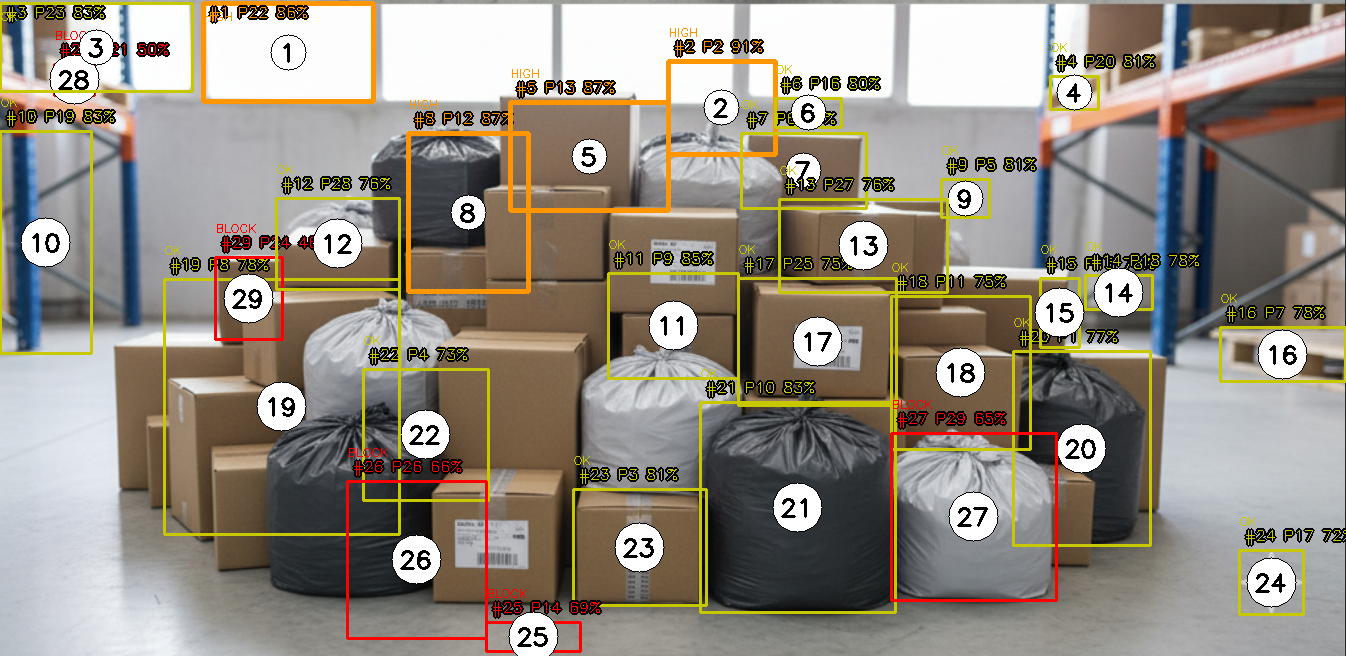

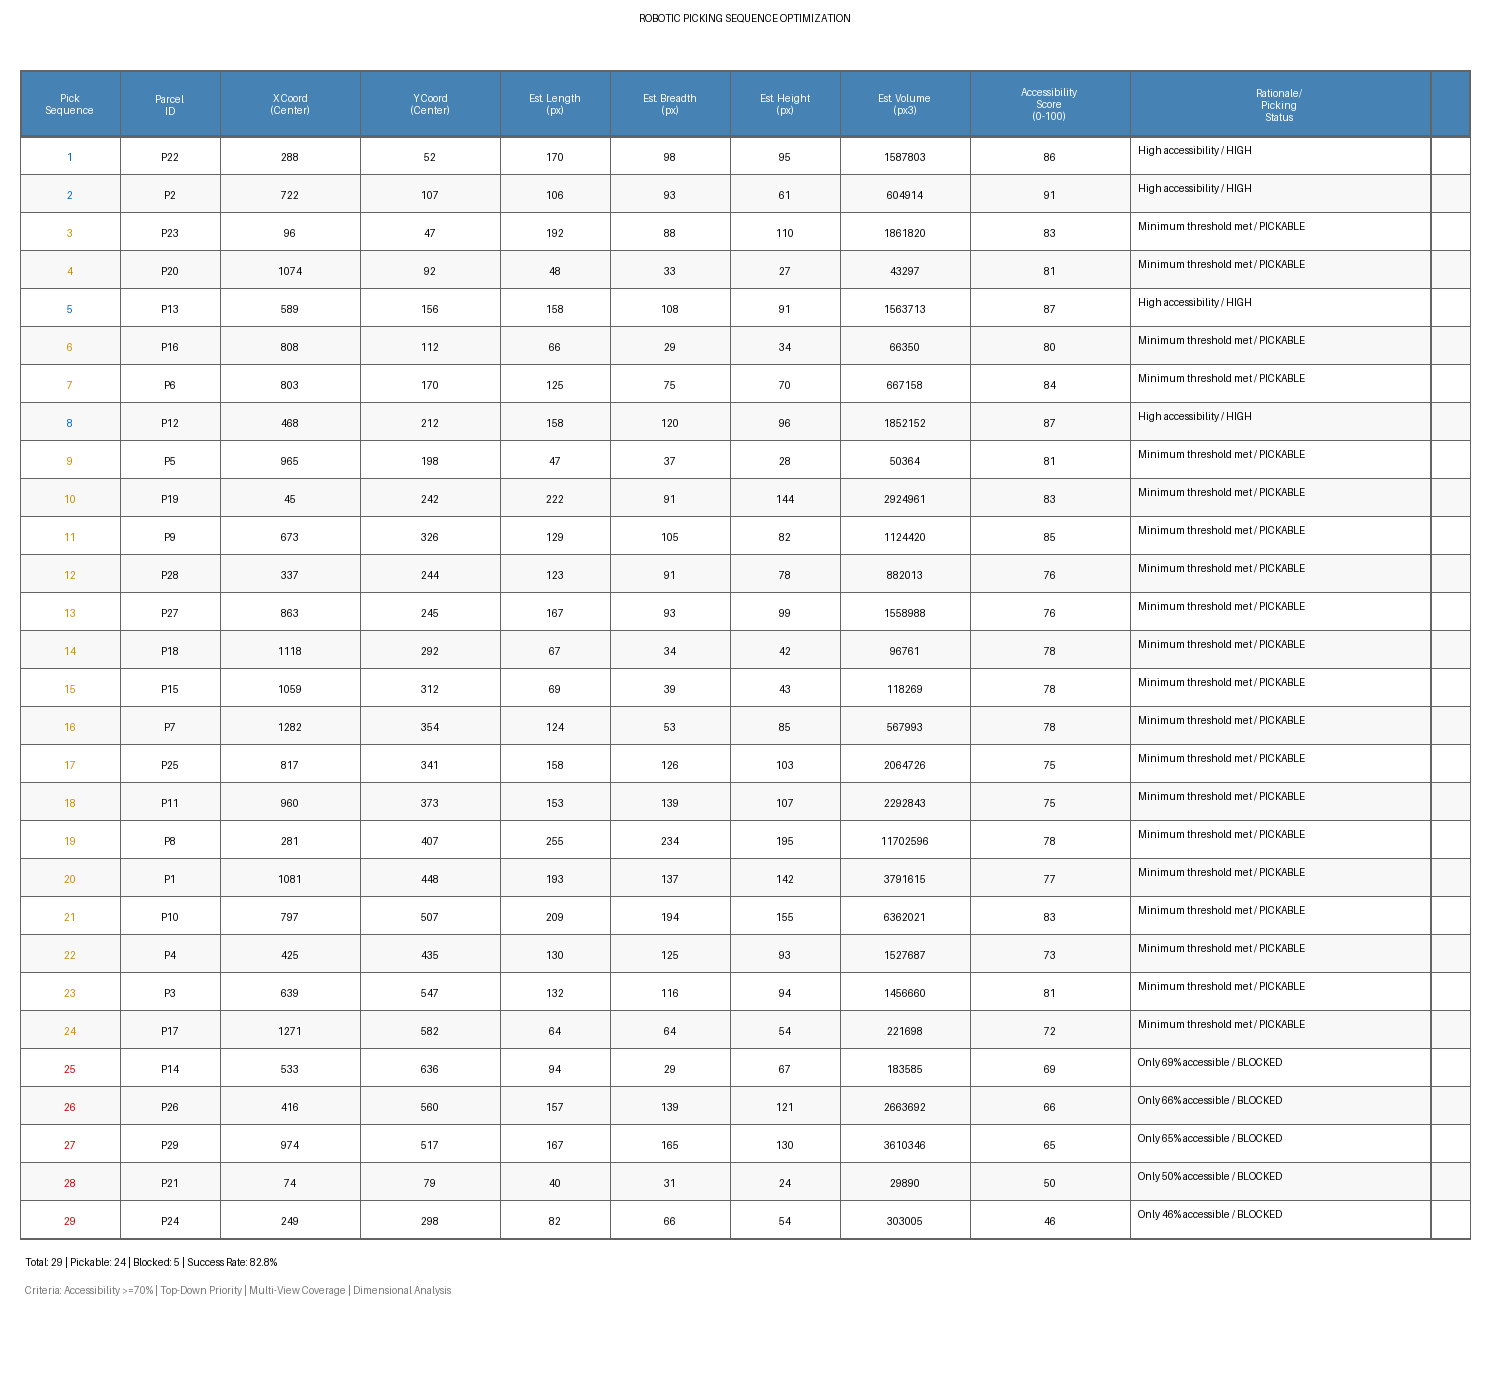

In [34]:
# CELL 4: Task 4 - Picking Sequence Optimization and Final output
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import pandas as pd


print("TASK 4: PICKING SEQUENCE OPTIMIZATION & FINAL OUTPUT")


# Check connectivity to prior tasks
try:
    print(f"Connected to Task 1: {len(merged_parcels)} parcels")
    print(f"Connected to Task 2: {len(task2_dimensional_data)} dimensional analyses")
    print(f"Connected to Task 3: Occlusion analysis available")
except NameError:
    print("ERROR: Run Tasks 1, 2, and 3 first!")
    raise Exception("Previous task variables not found.")

class PickingSequenceOptimizer:
    """Advanced picking sequence optimization for robotic parcel handling"""

    def __init__(self):
        self.MIN_ACCESSIBILITY_THRESHOLD = 0.70
        self.ACCESSIBILITY_WEIGHT = 0.6
        self.VERTICAL_POSITION_WEIGHT = 0.4

    def calculate_picking_priorities(self, parcels, dimensional_data, occlusion_analysis, img_shape):
        """Calculate comprehensive picking priorities for all parcels"""
        if not parcels:
            return []

        img_height, img_width = img_shape[:2]
        picking_candidates = []

        # Get occlusion analysis data
        occlusion_data = {}
        if occlusion_analysis and 'analysis_per_parcel' in occlusion_analysis:
            for analysis in occlusion_analysis['analysis_per_parcel']:
                parcel_idx = analysis.get('parcel_index', -1)
                if parcel_idx >= 0:
                    occlusion_data[parcel_idx] = analysis

        for i, parcel in enumerate(parcels):
            bbox = parcel.get('bbox', (0,0,0,0))
            centroid = parcel.get('centroid', ( (bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2 ))
            x1, y1, x2, y2 = bbox
            cx, cy = centroid

            # Get dimensional data
            dims = {}
            if dimensional_data and i < len(dimensional_data):
                dims = dimensional_data[i] or {}

            # Get occlusion analysis
            occlusion = occlusion_data.get(i, {})
            accessibility_score = occlusion.get('accessibility_score', 0.5)

            # Criterion 1: Accessibility Priority (70% threshold)
            accessibility_percent = accessibility_score * 100
            is_pickable = accessibility_score >= self.MIN_ACCESSIBILITY_THRESHOLD

            # Criterion 2: Vertical Position Priority (top is higher priority)
            normalized_y = cy / max(img_height, 1)
            vertical_priority = 1.0 - normalized_y

            # Combined priority score
            if is_pickable:
                priority_score = (
                    accessibility_score * self.ACCESSIBILITY_WEIGHT +
                    vertical_priority * self.VERTICAL_POSITION_WEIGHT
                )
            else:
                priority_score = 0

            # Determine status and rationale
            if not is_pickable:
                rationale = f"Only {accessibility_percent:.0f}% accessible"
                status = "BLOCKED"
            elif accessibility_percent >= 95:
                rationale = "Optimal position & accessibility"
                status = "PRIORITY"
            elif accessibility_percent >= 85:
                rationale = "High accessibility"
                status = "HIGH"
            elif accessibility_percent >= 70:
                rationale = "Minimum threshold met"
                status = "PICKABLE"
            else:
                rationale = "Below threshold"
                status = "BLOCKED"

            picking_candidates.append({
                'parcel_index': i,
                'parcel_id': parcel.get('ID', i),
                'center_x': int(cx),
                'center_y': int(cy),
                'bbox': bbox,
                'dimensions': dims,
                'accessibility_score': accessibility_score,
                'accessibility_percent': accessibility_percent,
                'vertical_priority': vertical_priority,
                'priority_score': priority_score,
                'is_pickable': is_pickable,
                'rationale': rationale,
                'status': status,
                'normalized_y': normalized_y,
                'views': parcel.get('views', []),
                'sources': parcel.get('sources', [])
            })

        return picking_candidates

    def generate_optimal_picking_sequence(self, picking_candidates):
        """Generate optimal picking sequence"""
        if not picking_candidates:
            return []

        pickable_parcels = [p for p in picking_candidates if p['is_pickable']]
        blocked_parcels = [p for p in picking_candidates if not p['is_pickable']]

        # sort pickable: higher priority_score first; among ties prefer higher (lower normalized_y)
        pickable_parcels.sort(key=lambda x: (x['priority_score'], -x['normalized_y']), reverse=True)
        # for blocked, highest accessibility first so we can try them later
        blocked_parcels.sort(key=lambda x: x['accessibility_score'], reverse=True)

        picking_sequence = []
        sequence_number = 1

        for parcel in pickable_parcels:
            parcel['sequence_number'] = sequence_number
            parcel['picking_order'] = "ACTIVE"
            picking_sequence.append(parcel)
            sequence_number += 1

        for parcel in blocked_parcels:
            parcel['sequence_number'] = sequence_number
            parcel['picking_order'] = "DEFERRED"
            picking_sequence.append(parcel)
            sequence_number += 1

        return picking_sequence

def create_comprehensive_table(picking_sequence, output_path):
    """Create comprehensive table with picking sequence data (LARGER FONTS)"""

    if not picking_sequence:
        print("No data to create table")
        return None

    # Build table rows in the requested format
    table_data = []
    for parcel in picking_sequence:
        dims = parcel.get('dimensions', {}) or {}
        est_length = int(dims.get('length_px', 0))
        est_breadth = int(dims.get('breadth_px', 0))
        # support either estimated_height_px or estimated_depth_px
        est_height = int(dims.get('estimated_height_px', dims.get('estimated_depth_px', 0) or 0))
        est_volume = int(dims.get('volume_px3', 0))
        access_score_0_100 = int(round(parcel.get('accessibility_percent', parcel.get('accessibility_score', 0)*100)))
        rationale = f"{parcel.get('rationale','')}"
        status_text = parcel.get('status', '')
        combined_rationale = f"{rationale} / {status_text}"

        row = {
            'Pick Sequence': parcel.get('sequence_number', 'N/A'),
            'Parcel ID': f"P{parcel['parcel_id']}",
            'X Coord (Center)': parcel.get('center_x', 0),
            'Y Coord (Center)': parcel.get('center_y', 0),
            'Est. Length (px)': est_length,
            'Est. Breadth (px)': est_breadth,
            'Est. Height (px)': est_height,
            'Est. Volume (px3)': est_volume,
            'Accessibility Score (0-100)': f"{access_score_0_100}",
            'Rationale/Picking Status': combined_rationale
        }
        table_data.append(row)

    df = pd.DataFrame(table_data)

    # Font sizes
    TITLE_FONTSZ = 32
    HEADER_FONTSZ = 22
    BODY_FONTSZ = 20

    # Try to load TTF fonts; fallback to default
    try:
        title_font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", TITLE_FONTSZ)
        header_font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", HEADER_FONTSZ)
        body_font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", BODY_FONTSZ)
    except Exception as e:
        # Fallback if environment doesn't have DejaVu
        print("Warning: TTF fonts not found, using default fonts. Error:", e)
        title_font = ImageFont.load_default()
        header_font = ImageFont.load_default()
        body_font = ImageFont.load_default()

    # Column widths (adjusted for larger font)
    col_widths = [100, 100, 140, 140, 110, 120, 110, 130, 160, 300]
    total_width = sum(col_widths) + 80
    row_height = int(BODY_FONTSZ * 1.9)  # taller rows for bigger font
    header_height = int(HEADER_FONTSZ * 3.0)
    title_height = int(TITLE_FONTSZ * 2.2)
    total_height = title_height + header_height + (len(table_data) * row_height) + 160

    # Create image
    img = Image.new('RGB', (total_width, total_height), 'white')
    draw = ImageDraw.Draw(img)

    # Colors
    header_color = (70, 130, 180)
    alt_row_color = (248, 248, 248)
    border_color = (100, 100, 100)
    text_color = (0, 0, 0)
    white = (255, 255, 255)

    # Title
    title = "ROBOTIC PICKING SEQUENCE OPTIMIZATION"
    title_bbox = draw.textbbox((0, 0), title, font=title_font)
    title_width = title_bbox[2] - title_bbox[0]
    title_x = (total_width - title_width) // 2
    draw.text((title_x, 12), title, fill=text_color, font=title_font)

    # Header area
    y_pos = title_height
    draw.rectangle([20, y_pos, total_width-20, y_pos + header_height], fill=header_color, outline=border_color, width=2)

    # Column headers
    headers = [
        "Pick\nSequence",
        "Parcel\nID",
        "X Coord\n(Center)",
        "Y Coord\n(Center)",
        "Est. Length\n(px)",
        "Est. Breadth\n(px)",
        "Est. Height\n(px)",
        "Est. Volume\n(px3)",
        "Accessibility\nScore\n(0-100)",
        "Rationale/\nPicking\nStatus"
    ]

    x_pos = 20
    for i, header in enumerate(headers):
        header_box = draw.multiline_textbbox((0,0), header, font=header_font, spacing=2)
        header_w = header_box[2] - header_box[0]
        header_h = header_box[3] - header_box[1]
        header_x = x_pos + (col_widths[i] - header_w) // 2
        header_y = y_pos + (header_height - header_h) // 2
        draw.multiline_text((header_x, header_y), header, fill=white, font=header_font, align="center", spacing=2)
        x_pos += col_widths[i]

    y_pos += header_height

    # Draw rows
    for row_idx, (_, row) in enumerate(df.iterrows()):
        bg_color = alt_row_color if row_idx % 2 == 1 else white
        draw.rectangle([20, y_pos, total_width-20, y_pos + row_height], fill=bg_color, outline=border_color)

        parcel = picking_sequence[row_idx]
        status = parcel.get('status','')
        if status == 'PRIORITY':
            status_color = (0, 140, 0)
        elif status == 'HIGH':
            status_color = (0, 100, 200)
        elif status == 'PICKABLE':
            status_color = (200, 140, 0)
        else:
            status_color = (200, 0, 0)

        x_pos = 20
        # Write each cell
        for i, (col_name, cell_value) in enumerate(row.items()):
            text = str(cell_value)
            # Special handling for the last column: wrap and left-align
            if col_name == 'Rationale/Picking Status':
                max_w = col_widths[i] - 14
                # naive word wrap
                words = text.split()
                lines = []
                cur = ""
                for w in words:
                    test = (cur + " " + w).strip()
                    test_bbox = draw.textbbox((0,0), test, font=body_font)
                    test_w = test_bbox[2] - test_bbox[0]
                    if test_w <= max_w:
                        cur = test
                    else:
                        if cur:
                            lines.append(cur)
                        cur = w
                if cur:
                    lines.append(cur)
                text_to_draw = "\n".join(lines)
                draw.multiline_text((x_pos + 8, y_pos + 8), text_to_draw, fill=text_color, font=body_font, spacing=4, align="left")
            else:
                text_bbox = draw.textbbox((0, 0), text, font=body_font)
                text_w = text_bbox[2] - text_bbox[0]
                text_h = text_bbox[3] - text_bbox[1]
                text_x = x_pos + (col_widths[i] - text_w) // 2
                text_y = y_pos + (row_height - text_h) // 2
                fill_color = status_color if col_name == 'Pick Sequence' else text_color
                draw.text((text_x, text_y), text, fill=fill_color, font=body_font)
            x_pos += col_widths[i]

        y_pos += row_height

    # Draw vertical separator lines
    x_pos = 20
    for width in col_widths:
        draw.line([x_pos, title_height, x_pos, y_pos], fill=border_color, width=1)
        x_pos += width
    draw.line([x_pos, title_height, x_pos, y_pos], fill=border_color, width=2)

    # Draw horizontal lines
    draw.line([20, title_height, total_width-20, title_height], fill=border_color, width=2)
    draw.line([20, title_height + header_height, total_width-20, title_height + header_height], fill=border_color, width=2)
    draw.line([20, y_pos, total_width-20, y_pos], fill=border_color, width=2)

    # Summary block
    pickable_count = sum(1 for p in picking_sequence if p.get('is_pickable'))
    blocked_count = len(picking_sequence) - pickable_count
    summary_y = y_pos + 18
    summary_text = f"Total: {len(picking_sequence)} | Pickable: {pickable_count} | Blocked: {blocked_count} | Success Rate: {(pickable_count/len(picking_sequence)*100):.1f}%"
    draw.text((25, summary_y), summary_text, fill=text_color, font=body_font)

    criteria_y = summary_y + 28
    criteria_text = "Criteria: Accessibility >=70% | Top-Down Priority | Multi-View Coverage | Dimensional Analysis"
    draw.text((25, criteria_y), criteria_text, fill=(120, 120, 120), font=body_font)

    # Save
    img.save(output_path, 'PNG', quality=95, dpi=(300, 300))
    print(f"Table saved to: {output_path}")
    return img

def draw_parcels_with_picking_sequence(img_bgr, parcels, picking_sequence=None):
    """Clean visualization — no black label backgrounds or header boxes"""
    out = img_bgr.copy()
    H, W = out.shape[:2]

    if len(parcels) == 0:
        cv2.putText(out, "No parcels detected", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        return out

    sequence_map = {}
    if picking_sequence:
        for parcel in picking_sequence:
            sequence_map[parcel['parcel_index']] = parcel

    for i, parcel in enumerate(parcels):
        bbox = parcel.get('bbox', (0, 0, 0, 0))
        x1, y1, x2, y2 = map(int, bbox)
        parcel_id = parcel.get('ID', i)
        picking_info = sequence_map.get(i, {})
        sequence_num = picking_info.get('sequence_number', 'N/A')
        status = picking_info.get('status', 'UNKNOWN')
        accessibility = picking_info.get('accessibility_percent', 0)

        # Color coding
        if status == 'PRIORITY':
            color = (0, 255, 0)
        elif status == 'HIGH':
            color = (0, 150, 255)
        elif status == 'PICKABLE':
            color = (0, 200, 200)
        elif status == 'BLOCKED':
            color = (0, 0, 255)
        else:
            color = (180, 180, 180)

        # Bounding box
        thickness = 3 if status in ['PRIORITY', 'HIGH'] else 2
        cv2.rectangle(out, (x1, y1), (x2, y2), color, thickness)

        # Label text
        label = f"#{sequence_num} P{parcel_id} {accessibility:.0f}%"
        text_scale = 0.5
        text_thick = 2
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, text_scale, text_thick)
        text_x, text_y = x1 + 5, max(y1 - 10, th + 5)
        cv2.putText(out, label, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, text_scale, (0, 0, 0), 3)  # outline
        cv2.putText(out, label, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, text_scale, color, 1)

        # Status tag
        status_short = {'PRIORITY': 'TOP', 'HIGH': 'HIGH', 'PICKABLE': 'OK', 'BLOCKED': 'BLOCK'}.get(status, status[:4])
        cv2.putText(out, status_short, (x1, max(20, y1 - 25)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

        # Center bubble
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        txt = str(sequence_num)
        tsize = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]
        radius = max(tsize[0] // 2 + 8, 18)
        cv2.circle(out, (cx, cy), radius, (255, 255, 255), -1)
        cv2.circle(out, (cx, cy), radius, (0, 0, 0), 1)
        cv2.putText(out, txt, (cx - tsize[0] // 2, cy + tsize[1] // 2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

    return out



#  EXECUTION
print("Generating optimal picking sequence...")

picking_optimizer = PickingSequenceOptimizer()
task4_picking_candidates = picking_optimizer.calculate_picking_priorities(
    merged_parcels, task2_dimensional_data, task3_occlusion_analysis, bottom_bgr.shape
)

task4_picking_sequence = picking_optimizer.generate_optimal_picking_sequence(task4_picking_candidates)

print("Creating final visualizations...")

# Create enhanced final visualization
final_on_bottom = draw_parcels_with_picking_sequence(bottom_bgr, merged_parcels, task4_picking_sequence)
cv2.imwrite(OUTPUT_PATH, final_on_bottom)

# Create comprehensive table
table_image = create_comprehensive_table(task4_picking_sequence, OUTPUT_TABLE_PATH)

print(f"\nTASK 4 RESULTS:")
print("="*40)

pickable_count = sum(1 for p in task4_picking_sequence if p['is_pickable']) if task4_picking_sequence else 0
total_count = len(task4_picking_sequence) if task4_picking_sequence else 0

print(f"Total parcels: {total_count}")
print(f"Pickable parcels (>=70% accessible): {pickable_count}")
print(f"Blocked parcels: {total_count - pickable_count}")
print(f"Success rate: {(pickable_count/max(total_count,1)*100):.1f}%")

print(f"\nFiles generated:")
print(f"  Final visualization: {OUTPUT_PATH}")
print(f"  Picking sequence table: {OUTPUT_TABLE_PATH}")

print(f"\nDisplaying final results:")
# display images
try:
    cv2_imshow(final_on_bottom)
except:
    # fallback: show with OpenCV window
    cv2.imwrite("/tmp/final_on_bottom_preview.png", final_on_bottom)
    print("Saved final visualization preview to /tmp/final_on_bottom_preview.png")

if table_image:
    table_cv = cv2.cvtColor(np.array(table_image), cv2.COLOR_RGB2BGR)
    try:
        cv2_imshow(table_cv)
    except:
        cv2.imwrite("/tmp/picking_table_preview.png", table_cv)
        print("Saved table preview to /tmp/picking_table_preview.png")
